# V-CoT: Visual Chain-of-Thought Training

**Grounding Reasoning in Vision-Language Models**

This notebook provides an end-to-end pipeline for:
1. **Setup**: Install dependencies and mount Google Drive
2. **Data Generation**: Distill reasoning traces from GPT-4o
3. **Training**: Fine-tune Qwen2.5-VL with QLoRA using Unsloth
4. **Evaluation**: Measure IoU and accuracy metrics
5. **Demo**: Interactive Gradio interface

**Requirements:**
- Google Colab with GPU (T4/A100 recommended)
- OpenAI API key (for data generation)
- HuggingFace token (optional, for gated models)

---
## 1. Setup & Configuration

In [ ]:
#@title 1.1 Configuration { display-mode: "form" }
#@markdown ### Project Settings
PROJECT_NAME = "V-CoT"  #@param {type:"string"}
SAVE_TO_DRIVE = True  #@param {type:"boolean"}

#@markdown ### API Keys (stored securely)
USE_COLAB_SECRETS = True  #@param {type:"boolean"}

#@markdown ---
#@markdown ### Training Settings (Optimized for Best Performance)
MAX_STEPS = -1  #@param {type:"integer"}
#@markdown Set to -1 to use NUM_EPOCHS instead
NUM_EPOCHS = 2  #@param {type:"integer"}
BATCH_SIZE = 4  #@param {type:"integer"}
GRADIENT_ACCUMULATION = 4  #@param {type:"integer"}
#@markdown Effective batch size = BATCH_SIZE × GRADIENT_ACCUMULATION = 16
LEARNING_RATE = 1e-4  #@param {type:"number"}
LORA_RANK = 64  #@param {type:"integer"}
LORA_ALPHA = 128  #@param {type:"integer"}

#@markdown ---
#@markdown ### Data Generation Settings
MAX_SAMPLES = 150000  #@param {type:"integer"}
#@markdown 150K samples recommended for best quality
GENERATE_NEW_DATA = False  #@param {type:"boolean"}

#@markdown ---
#@markdown ### Resume Training
RESUME_FROM_CHECKPOINT = True  #@param {type:"boolean"}

import os

# Set paths
DRIVE_BASE = f"/content/drive/MyDrive/Colab Notebooks/{PROJECT_NAME}"
LOCAL_BASE = f"/content/{PROJECT_NAME}"
CHECKPOINT_DIR = f"{DRIVE_BASE}/checkpoints" if SAVE_TO_DRIVE else f"{LOCAL_BASE}/outputs/checkpoints"
DATA_DIR = f"{DRIVE_BASE}/data" if SAVE_TO_DRIVE else f"{LOCAL_BASE}/data/processed"
LOG_DIR = f"{DRIVE_BASE}/logs" if SAVE_TO_DRIVE else f"{LOCAL_BASE}/logs"

print(f"Project: {PROJECT_NAME}")
print(f"Checkpoint directory: {CHECKPOINT_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"\n--- Training Config ---")
print(f"Epochs: {NUM_EPOCHS}" if MAX_STEPS == -1 else f"Max steps: {MAX_STEPS}")
print(f"Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"LoRA rank: {LORA_RANK}, alpha: {LORA_ALPHA}")
print(f"Max samples: {MAX_SAMPLES}")

Project: V-CoT
Checkpoint directory: /content/drive/MyDrive/Colab Notebooks/V-CoT/checkpoints
Data directory: /content/drive/MyDrive/Colab Notebooks/V-CoT/data

--- Training Config ---
Epochs: 2
Effective batch size: 16
Learning rate: 0.0001
LoRA rank: 64, alpha: 128
Max samples: 150000


In [ ]:
#@title 1.2 Mount Google Drive { display-mode: "form" }
from google.colab import drive

if SAVE_TO_DRIVE:
    drive.mount('/content/drive')

    # Create project directories in Drive
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)
    os.makedirs(LOG_DIR, exist_ok=True)

    print(f"\n✓ Google Drive mounted")
    print(f"✓ Created directories in: {DRIVE_BASE}")

    # List existing checkpoints
    if os.path.exists(CHECKPOINT_DIR):
        checkpoints = [d for d in os.listdir(CHECKPOINT_DIR) if d.startswith('checkpoint-')]
        if checkpoints:
            print(f"\nExisting checkpoints found:")
            for cp in sorted(checkpoints):
                print(f"  - {cp}")
        else:
            print("\nNo existing checkpoints found.")
else:
    print("Saving to local storage (will be lost when runtime disconnects)")

Mounted at /content/drive

✓ Google Drive mounted
✓ Created directories in: /content/drive/MyDrive/Colab Notebooks/V-CoT

Existing checkpoints found:
  - checkpoint-12654
  - checkpoint-4218
  - checkpoint-8436


In [ ]:
#@title 1.3 Setup API Keys { display-mode: "form" }
import os

if USE_COLAB_SECRETS:
    try:
        from google.colab import userdata

        # Try to get keys from Colab secrets
        try:
            os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
            print("✓ OPENAI_API_KEY loaded from Colab secrets")
        except:
            print("⚠ OPENAI_API_KEY not found in secrets")

        try:
            os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')
            print("✓ HF_TOKEN loaded from Colab secrets")
        except:
            print("⚠ HF_TOKEN not found in secrets (optional)")

        try:
            os.environ['DEEPINFRA_API_KEY'] = userdata.get('DEEPINFRA_API_KEY')
            print("✓ DEEPINFRA_API_KEY loaded from Colab secrets")
        except:
            print("⚠ DEEPINFRA_API_KEY not found in secrets (optional)")

        try:
            os.environ['OPENROUTER_API_KEY'] = userdata.get('OPENROUTER_API_KEY')
            print("✓ OPENROUTER_API_KEY loaded from Colab secrets")
        except:
            print("⚠ OPENROUTER_API_KEY not found in secrets (optional)")

    except ImportError:
        print("Not running in Colab, skipping secrets")
else:
    # Manual input
    from getpass import getpass

    if not os.environ.get('OPENAI_API_KEY'):
        os.environ['OPENAI_API_KEY'] = getpass('Enter OpenAI API Key: ')

    if not os.environ.get('HF_TOKEN'):
        hf_token = getpass('Enter HuggingFace Token (press Enter to skip): ')
        if hf_token:
            os.environ['HF_TOKEN'] = hf_token

✓ OPENAI_API_KEY loaded from Colab secrets
✓ HF_TOKEN loaded from Colab secrets
✓ DEEPINFRA_API_KEY loaded from Colab secrets
✓ OPENROUTER_API_KEY loaded from Colab secrets


In [ ]:
#@title 1.4 Install Dependencies { display-mode: "form" }
# First, fix NumPy version (must be done before other installs)
!pip uninstall numpy -y
!pip install "numpy<2.0.0"

# Install Unsloth (optimized for Colab)
!pip install --no-deps trl peft accelerate bitsandbytes
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# Install other dependencies
!pip install transformers>=4.45.0 datasets openai gradio opencv-python pyyaml tqdm scipy wandb

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 139.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.4/517.4 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 46.4 MB/s eta 0:00:00
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-3flym3ga/unsloth_253540c3364a4000bc46bc87688db055
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-3flym3ga/unsloth_253540c3364a4000bc46bc87688db055
  Resolved https://github.com/unslothai/unsloth.git to commit 71d1adb13efc38b995a5526b7295d72b3aac9437
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.3/289.3 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 53.5 MB/s eta 0:00

In [ ]:
!pip install tenacity

In [ ]:
#@title 1.5 Verify GPU & Installation { display-mode: "form" }
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("\n⚠️ WARNING: No GPU detected! Training will be extremely slow.")
    print("Go to Runtime > Change runtime type > Select GPU")

# Verify Unsloth
try:
    from unsloth import FastVisionModel
    print("\n✓ Unsloth installed successfully")
except ImportError as e:
    print(f"\n✗ Unsloth installation failed: {e}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
GPU Memory: 42.5 GB
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!

✓ Unsloth installed successfully


## 2. Data Preparation (VisCOT Dataset)

Download and convert the [VisCOT dataset](https://huggingface.co/datasets/deepcs233/Visual-CoT) which contains **438K samples with real bounding boxes**.

In [ ]:
#@title 2.1 Download & Convert VisCOT Dataset { display-mode: "form" }
import os
import json
import re
from pathlib import Path
from tqdm import tqdm
from datasets import load_dataset

#@markdown Uses MAX_SAMPLES from config (default 150K)
BBOX_FORMAT = "vcot"  #@param ["vcot", "qwen_native"]
FILTER_QUALITY = True  #@param {type:"boolean"}
#@markdown Filter to keep only high-quality samples with bboxes

output_dir = Path(DATA_DIR)
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {output_dir}")
print(f"Max samples: {MAX_SAMPLES}")

print("\nLoading VisCOT dataset...")
dataset = load_dataset("deepcs233/Visual-CoT", data_files="viscot_363k.json", split="train")
print(f"Loaded {len(dataset)} samples from VisCOT")

def parse_bbox_from_text(text):
    """Extract bbox from text like '[0.562, 0.228, 0.646, 0.292]'"""
    match = re.search(r'\[([0-9.]+),\s*([0-9.]+),\s*([0-9.]+),\s*([0-9.]+)\]', text)
    if match:
        try:
            coords = [float(match.group(i)) for i in range(1, 5)]
            if all(0 <= c <= 1 for c in coords):
                return [int(c * 1000) for c in coords]
            elif all(c <= 1000 for c in coords):
                return [int(c) for c in coords]
        except:
            pass
    return None

def format_bbox(bbox, fmt="vcot"):
    if not bbox:
        return None
    x1, y1, x2, y2 = bbox
    if fmt == "vcot":
        return f"<box>[{x1}, {y1}, {x2}, {y2}]</box>"
    else:
        return f"<|box_start|>({y1},{x1}),({y2},{x2})<|box_end|>"

def convert_sample(sample):
    conversations = sample.get('conversations', [])
    images = sample.get('image', [])

    if not conversations or len(conversations) < 2:
        return None

    image_path = None
    for img in images:
        if isinstance(img, str) and '###' not in img:
            image_path = img
            break
    if not image_path and images:
        image_path = images[0].split('###')[0] if '###' in str(images[0]) else images[0]

    if not image_path:
        return None

    question = None
    bbox = None
    answer = None

    for turn in conversations:
        role = turn.get('from', '')
        value = turn.get('value', '')

        if role == 'human' and '<image>' in value:
            q = value.replace('<image>', '').strip()
            if q and not question:
                question = q
        elif role == 'gpt':
            parsed_bbox = parse_bbox_from_text(value)
            if parsed_bbox and not bbox:
                bbox = parsed_bbox
            elif value and not value.startswith('['):
                answer = value.strip()

    if not question:
        return None

    # Build response
    response_parts = []
    if answer:
        response_parts.append(answer)

    has_bbox = False
    if bbox:
        bbox_str = format_bbox(bbox, BBOX_FORMAT)
        if bbox_str:
            has_bbox = True
            obj_ref = answer[:30] if answer and len(answer) < 50 else "relevant region"
            response_parts.append(f"\n\nThe <ref>{obj_ref}</ref>{bbox_str} shows this in the image.")

    if not response_parts:
        return None

    # Quality filter: require bbox if enabled
    if FILTER_QUALITY and not has_bbox:
        return None

    return {
        "messages": [
            {"role": "user", "content": [
                {"type": "image", "image": image_path},
                {"type": "text", "text": question}
            ]},
            {"role": "assistant", "content": "".join(response_parts)}
        ],
        "metadata": {"source": "viscot", "dataset": sample.get('dataset', 'unknown'), "has_bbox": has_bbox}
    }

print(f"\n--- Converting up to {MAX_SAMPLES} samples ---")
converted = []
with_bbox = 0

for i, sample in enumerate(tqdm(dataset, total=min(len(dataset), MAX_SAMPLES))):
    if len(converted) >= MAX_SAMPLES:
        break
    result = convert_sample(sample)
    if result:
        converted.append(result)
        if result["metadata"]["has_bbox"]:
            with_bbox += 1

print(f"\nConverted: {len(converted)} samples")
print(f"With bounding boxes: {with_bbox} ({100*with_bbox/max(1,len(converted)):.1f}%)")

if converted:
    val_size = max(1, int(len(converted) * 0.1))
    val_data = converted[:val_size]
    train_data = converted[val_size:]

    with open(output_dir / "train.jsonl", 'w') as f:
        for x in train_data:
            f.write(json.dumps(x) + "\n")
    with open(output_dir / "val.jsonl", 'w') as f:
        for x in val_data:
            f.write(json.dumps(x) + "\n")

    print(f"\n✓ Saved {len(train_data)} training samples")
    print(f"✓ Saved {len(val_data)} validation samples")
    print(f"\n--- Example ---")
    print(f"Q: {converted[0]['messages'][0]['content'][1]['text'][:80]}...")
    print(f"A: {converted[0]['messages'][1]['content'][:150]}...")
else:
    print("\n⚠️ No samples converted!")

Output directory: /content/drive/MyDrive/Colab Notebooks/V-CoT/data
Max samples: 150000

Loading VisCOT dataset...


README.md: 0.00B [00:00, ?B/s]

viscot_363k.json:   0%|          | 0.00/345M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loaded 404120 samples from VisCOT

--- Converting up to 150000 samples ---


100%|██████████| 150000/150000 [00:17<00:00, 8818.02it/s]



Converted: 150000 samples
With bounding boxes: 150000 (100.0%)

✓ Saved 135000 training samples
✓ Saved 15000 validation samples

--- Example ---
Q: Can you tell me about the hairstyles of the individuals in the image? Please pro...
A: They have shaggy hair.

The <ref>They have shaggy hair.</ref><box>[562, 228, 646, 292]</box> shows this in the image....


In [ ]:
#@title 2.2 Analyze Converted Data { display-mode: "form" }
import json
import re

def analyze_converted_data(file_path):
    """Analyze the converted dataset for valid bounding boxes."""

    stats = {
        'total': 0,
        'has_vcot_box': 0,
        'has_qwen_box': 0,
        'has_ref': 0,
        'avg_response_len': 0
    }

    response_lengths = []

    with open(file_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue

            stats['total'] += 1
            sample = json.loads(line)
            response = sample['messages'][1]['content']

            response_lengths.append(len(response))

            if '<ref>' in response:
                stats['has_ref'] += 1
            if '<box>[' in response:
                stats['has_vcot_box'] += 1
            if '<|box_start|>' in response:
                stats['has_qwen_box'] += 1

    stats['avg_response_len'] = sum(response_lengths) / len(response_lengths) if response_lengths else 0

    return stats

train_stats = analyze_converted_data(f"{DATA_DIR}/train.jsonl")
val_stats = analyze_converted_data(f"{DATA_DIR}/val.jsonl")

print("=" * 50)
print("CONVERTED DATA ANALYSIS")
print("=" * 50)

print(f"\n--- Training Data ---")
print(f"Total samples:        {train_stats['total']}")
print(f"With <ref> tags:      {train_stats['has_ref']} ({100*train_stats['has_ref']/max(1,train_stats['total']):.1f}%)")
print(f"With V-CoT <box>:     {train_stats['has_vcot_box']} ({100*train_stats['has_vcot_box']/max(1,train_stats['total']):.1f}%)")
print(f"With Qwen native box: {train_stats['has_qwen_box']} ({100*train_stats['has_qwen_box']/max(1,train_stats['total']):.1f}%)")
print(f"Avg response length:  {train_stats['avg_response_len']:.0f} chars")

print(f"\n--- Validation Data ---")
print(f"Total samples:        {val_stats['total']}")
print(f"With <ref> tags:      {val_stats['has_ref']} ({100*val_stats['has_ref']/max(1,val_stats['total']):.1f}%)")
print(f"With V-CoT <box>:     {val_stats['has_vcot_box']} ({100*val_stats['has_vcot_box']/max(1,val_stats['total']):.1f}%)")

# Show example with bbox
print("\n--- Example with Bounding Box ---")
with open(f"{DATA_DIR}/train.jsonl", 'r') as f:
    for line in f:
        sample = json.loads(line)
        response = sample['messages'][1]['content']
        if '<box>' in response or '<|box_start|>' in response:
            print(f"Q: {sample['messages'][0]['content'][1]['text']}")
            print(f"A: {response[:500]}...")
            break

print("\n✓ Data ready for training!")

CONVERTED DATA ANALYSIS

--- Training Data ---
Total samples:        135000
With <ref> tags:      135000 (100.0%)
With V-CoT <box>:     135000 (100.0%)
With Qwen native box: 0 (0.0%)
Avg response length:  153 chars

--- Validation Data ---
Total samples:        15000
With <ref> tags:      15000 (100.0%)
With V-CoT <box>:     15000 (100.0%)

--- Example with Bounding Box ---
Q: What is the activity of the dog in the image? Please provide the bounding box coordinate of the region that can help you answer the question better.
A: The dog is running, which is evident from its open mouth and the position of its body.

The <ref>relevant region</ref><box>[258, 436, 328, 484]</box> shows this in the image....

✓ Data ready for training!


---
## 3. Model Training

In [ ]:
#@title 3.1 Load Model with Unsloth (Optimized) { display-mode: "form" }
from unsloth import FastVisionModel
import torch

#@markdown ### Model Settings
MODEL_ID = "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit"  #@param {type:"string"}
MAX_SEQ_LENGTH = 2048  #@param {type:"integer"}
#@markdown Longer context for complex reasoning

print(f"Loading {MODEL_ID}...")
print(f"LoRA config: rank={LORA_RANK}, alpha={LORA_ALPHA}")

model, tokenizer = FastVisionModel.from_pretrained(
    MODEL_ID,
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)

# Apply LoRA with optimized settings
model = FastVisionModel.get_peft_model(
    model,
    r=LORA_RANK,
    lora_alpha=LORA_ALPHA,
    lora_dropout=0.05,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=42,
)

# Print trainable parameters
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"\n✓ Model loaded successfully")
print(f"Trainable parameters: {trainable:,} / {total:,} ({100*trainable/total:.2f}%)")
print(f"Memory usage: {torch.cuda.memory_allocated()/1024**3:.1f} GB")

Loading unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit...
LoRA config: rank=64, alpha=128
==((====))==  Unsloth 2025.12.5: Fast Qwen2_5_Vl patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.90G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.



✓ Model loaded successfully
Trainable parameters: 190,357,504 / 5,219,879,936 (3.65%)
Memory usage: 7.1 GB


In [ ]:
from pathlib import Path
train_file = Path(DATA_DIR) / "train.jsonl"
val_file = Path(DATA_DIR) / "val.jsonl"

In [ ]:
#@title 3.2 Prepare Dataset { display-mode: "form" }
import json
import re
from datasets import Dataset
from tqdm import tqdm

def load_jsonl(file_path):
    """Load JSONL file."""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data

def convert_messages_to_text(messages):
    """
    Convert messages to plain text format without using chat template.
    This avoids issues with the VLM tokenizer's special handling.
    """
    text_parts = []

    for msg in messages:
        role = msg.get("role", "")
        content = msg.get("content", "")

        if role == "system":
            text_parts.append(f"<|im_start|>system\n{content}<|im_end|>")
        elif role == "user":
            # Handle user content which may be a list (with image + text)
            if isinstance(content, list):
                # Extract just the text parts, skip image references
                text_content = ""
                for item in content:
                    if isinstance(item, dict) and item.get("type") == "text":
                        text_content += item.get("text", "")
                content = text_content
            text_parts.append(f"<|im_start|>user\n{content}<|im_end|>")
        elif role == "assistant":
            text_parts.append(f"<|im_start|>assistant\n{content}<|im_end|>")

    # Add system message if not present
    if not any("<|im_start|>system" in p for p in text_parts):
        text_parts.insert(0, "<|im_start|>system\nYou are a helpful assistant.<|im_end|>")

    return "\n".join(text_parts)

# Get the underlying text tokenizer from the VLM processor
# The Qwen2-VL tokenizer is a processor that wraps both image and text tokenizers
print("Extracting text tokenizer from VLM processor...")
if hasattr(tokenizer, 'tokenizer'):
    # It's a processor with a nested tokenizer
    text_tokenizer = tokenizer.tokenizer
    print(f"  Found nested tokenizer: {type(text_tokenizer).__name__}")
elif hasattr(tokenizer, 'text_tokenizer'):
    text_tokenizer = tokenizer.text_tokenizer
    print(f"  Found text_tokenizer: {type(text_tokenizer).__name__}")
else:
    # Try to use AutoTokenizer directly
    from transformers import AutoTokenizer
    print("  Loading separate text tokenizer...")
    text_tokenizer = AutoTokenizer.from_pretrained(
        "Qwen/Qwen2.5-7B-Instruct",
        trust_remote_code=True
    )
    print(f"  Loaded: {type(text_tokenizer).__name__}")

# Test the text tokenizer
test_text = "Hello world"
test_encoding = text_tokenizer(test_text, return_tensors=None)
print(f"  Test encoding: {test_encoding['input_ids'][:5]}...")

def prepare_text_only_dataset(data, tok, max_length=2048):
    """
    Prepare dataset by pre-tokenizing to avoid collator issues.
    """
    processed = []
    skipped = 0
    first_error = None

    for i, sample in enumerate(tqdm(data, desc="Tokenizing")):
        try:
            messages = sample.get("messages", [])

            # Convert to plain text format
            text = convert_messages_to_text(messages)

            if not text or len(text) < 10:
                skipped += 1
                continue

            # Tokenize with the TEXT tokenizer (not the VLM processor)
            encoding = tok(
                text,
                truncation=True,
                max_length=max_length,
                padding=False,
                return_tensors=None,
            )

            # Add labels (same as input_ids for causal LM)
            processed.append({
                "input_ids": encoding["input_ids"],
                "attention_mask": encoding["attention_mask"],
                "labels": encoding["input_ids"].copy(),
            })

        except Exception as e:
            if first_error is None:
                first_error = f"Sample {i}: {str(e)[:200]}"
            skipped += 1
            continue

    if skipped > 0:
        print(f"  ⚠ Skipped {skipped} samples")
        if first_error:
            print(f"  First error: {first_error}")

    return processed

# Load raw data
print("\nLoading data...")
train_data_raw = load_jsonl(train_file)
val_data_raw = load_jsonl(val_file) if os.path.exists(val_file) else []

print(f"  Raw training samples: {len(train_data_raw)}")
print(f"  Raw validation samples: {len(val_data_raw)}")

# Pre-tokenize the data using the TEXT tokenizer
print("\nPre-tokenizing training data...")
train_data_tokenized = prepare_text_only_dataset(train_data_raw, text_tokenizer, max_length=2048)

print("\nPre-tokenizing validation data...")
val_data_tokenized = prepare_text_only_dataset(val_data_raw, text_tokenizer, max_length=2048) if val_data_raw else []

print(f"\n  Tokenized training samples: {len(train_data_tokenized)}")
print(f"  Tokenized validation samples: {len(val_data_tokenized)}")

if len(train_data_tokenized) == 0:
    raise ValueError("No training samples were tokenized! Check the error messages above.")

# Create HuggingFace datasets
print("\nCreating datasets...")
train_dataset = Dataset.from_list(train_data_tokenized)

if val_data_tokenized:
    val_dataset = Dataset.from_list(val_data_tokenized)
else:
    val_dataset = None

print(f"\n✓ Datasets prepared successfully!")
print(f"  Training: {len(train_dataset)} samples")
if val_dataset:
    print(f"  Validation: {len(val_dataset)} samples")

# Show sample info
print(f"\n📝 Sample tokenized data:")
print(f"  Input IDs length: {len(train_dataset[0]['input_ids'])}")
print(f"  First 20 tokens: {train_dataset[0]['input_ids'][:20]}")

# Decode a sample to verify
decoded = text_tokenizer.decode(train_dataset[0]['input_ids'][:200])
print(f"\n📝 Decoded sample (first 200 tokens):")
print("-" * 50)
print(decoded)
print("-" * 50)


Extracting text tokenizer from VLM processor...
  Found nested tokenizer: Qwen2TokenizerFast
  Test encoding: [9707, 1879]...

Loading data...
  Raw training samples: 135000
  Raw validation samples: 15000

Pre-tokenizing training data...


Tokenizing: 100%|██████████| 135000/135000 [01:00<00:00, 2229.89it/s]



Pre-tokenizing validation data...


Tokenizing: 100%|██████████| 15000/15000 [00:07<00:00, 2055.57it/s]



  Tokenized training samples: 135000
  Tokenized validation samples: 15000

Creating datasets...

✓ Datasets prepared successfully!
  Training: 135000 samples
  Validation: 15000 samples

📝 Sample tokenized data:
  Input IDs length: 106
  First 20 tokens: [151644, 8948, 198, 2610, 525, 264, 10950, 17847, 13, 151645, 198, 151644, 872, 198, 3838, 374, 279, 5702, 315, 279]

📝 Decoded sample (first 200 tokens):
--------------------------------------------------
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What is the activity of the dog in the image? Please provide the bounding box coordinate of the region that can help you answer the question better.<|im_end|>
<|im_start|>assistant
The dog is running, which is evident from its open mouth and the position of its body.

The <ref>relevant region</ref><box>[258, 436, 328, 484]</box> shows this in the image.<|im_end|>
--------------------------------------------------


In [ ]:
#@title 3.3 Setup Trainer (Optimized for Best Performance) { display-mode: "form" }
from trl import SFTTrainer, SFTConfig
from transformers import EarlyStoppingCallback, DataCollatorForSeq2Seq
import torch
import os

# Check bfloat16 support
def is_bf16_supported():
    if torch.cuda.is_available():
        return torch.cuda.is_bf16_supported()
    return False

# Find latest checkpoint for resuming
def find_latest_checkpoint(checkpoint_dir):
    if not os.path.exists(checkpoint_dir):
        return None
    checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith('checkpoint-')]
    if not checkpoints:
        return None
    latest = max(checkpoints, key=lambda x: int(x.split('-')[1]))
    return os.path.join(checkpoint_dir, latest)

resume_checkpoint = find_latest_checkpoint(CHECKPOINT_DIR) if RESUME_FROM_CHECKPOINT else None
if resume_checkpoint:
    print(f"✓ Will resume from: {resume_checkpoint}")
else:
    print("Starting fresh training")

# Calculate steps
total_samples = len(train_dataset)
effective_batch = BATCH_SIZE * GRADIENT_ACCUMULATION
steps_per_epoch = total_samples // effective_batch

if MAX_STEPS == -1:
    total_steps = steps_per_epoch * NUM_EPOCHS
    print(f"\nTraining for {NUM_EPOCHS} epochs = {total_steps} steps")
else:
    total_steps = MAX_STEPS
    print(f"\nTraining for {total_steps} steps")

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Effective batch size: {effective_batch}")

# Use standard data collator for pre-tokenized data
data_collator = DataCollatorForSeq2Seq(
    tokenizer=text_tokenizer,  # Use the text tokenizer we extracted
    padding=True,
    return_tensors="pt",
)

# Check bf16 support
use_bf16 = is_bf16_supported()
print(f"Using {'bf16' if use_bf16 else 'fp16'} precision")

# Optimized training arguments
training_args = SFTConfig(
    output_dir=CHECKPOINT_DIR,

    # Duration
    num_train_epochs=NUM_EPOCHS if MAX_STEPS == -1 else None,
    max_steps=MAX_STEPS if MAX_STEPS != -1 else -1,

    # Batch size
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,

    # Learning rate with cosine schedule
    learning_rate=LEARNING_RATE,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,

    # Regularization
    weight_decay=0.01,
    max_grad_norm=0.3,

    # NEFTune - adds noise to embeddings for better generalization
    neftune_noise_alpha=5,

    # Efficiency
    max_seq_length=2048,
    packing=False,
    fp16=not use_bf16,
    bf16=use_bf16,
    gradient_checkpointing=True,
    optim="adamw_8bit",

    # Evaluation & Early Stopping
    eval_strategy="steps",
    eval_steps=max(500, steps_per_epoch // 4),
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    # Saving
    save_strategy="steps",
    save_steps=max(500, steps_per_epoch // 2),
    save_total_limit=3,

    # Logging
    logging_steps=50,
    logging_first_step=True,
    report_to="tensorboard",

    # Resume
    resume_from_checkpoint=resume_checkpoint,

    # Other
    seed=42,
    dataloader_num_workers=0,
    remove_unused_columns=True,
)

# Create trainer with text_tokenizer (required for Unsloth internal operations)
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=text_tokenizer,  # Pass the text tokenizer
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3,
            early_stopping_threshold=0.001
        )
    ],
)

print(f"\n✓ Trainer configured")
print(f"\n--- Training Summary ---")
print(f"Model: {MODEL_ID}")
print(f"LoRA: rank={LORA_RANK}, alpha={LORA_ALPHA}")
print(f"Samples: {len(train_dataset)} train, {len(val_dataset) if val_dataset else 0} val")
print(f"Epochs: {NUM_EPOCHS if MAX_STEPS == -1 else 'N/A'}")
print(f"Total steps: ~{total_steps}")
print(f"Batch size: {BATCH_SIZE} x {GRADIENT_ACCUMULATION} = {effective_batch}")
print(f"Learning rate: {LEARNING_RATE} (cosine decay)")
print(f"NEFTune: alpha=5")
print(f"Early stopping: patience=3")
print(f"\nEstimated time on L4: {total_steps * 1.2 / 3600:.1f} hours")


Starting fresh training

Training for 2 epochs = 16874 steps
Steps per epoch: 8437
Effective batch size: 16
Using bf16 precision

✓ Trainer configured

--- Training Summary ---
Model: unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit
LoRA: rank=64, alpha=128
Samples: 135000 train, 15000 val
Epochs: 2
Total steps: ~16874
Batch size: 4 x 4 = 16
Learning rate: 0.0001 (cosine decay)
NEFTune: alpha=5
Early stopping: patience=3

Estimated time on L4: 5.6 hours


In [ ]:
#@title 3.4 Start Training { display-mode: "form" }
print("="*60)
print("STARTING TRAINING")
print("="*60)
if resume_checkpoint:
    print(f"Resuming from: {resume_checkpoint}")
print(f"Checkpoints saved to: {CHECKPOINT_DIR}")
print("="*60 + "\n")

# Train
trainer_stats = trainer.train(resume_from_checkpoint=resume_checkpoint)

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Total steps: {trainer_stats.global_step}")
print(f"Training loss: {trainer_stats.training_loss:.4f}")

The model is already on multiple devices. Skipping the move to device specified in `args`.


STARTING TRAINING
Checkpoints saved to: /content/drive/MyDrive/Colab Notebooks/V-CoT/checkpoints



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 135,000 | Num Epochs = 2 | Total steps = 16,876
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 190,357,504 of 8,482,524,160 (2.24% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
2109,0.640000,0.621313
4218,0.627100,0.615283
6327,0.617400,0.606876
8436,0.618800,0.602355


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Step,Training Loss,Validation Loss
2109,0.640000,0.621313
4218,0.627100,0.615283
6327,0.617400,0.606876
8436,0.618800,0.602355
10545,0.577600,0.605943
12654,0.574400,0.603836
14763,0.562700,0.602989



TRAINING COMPLETE
Total steps: 14763
Training loss: 0.6164


In [ ]:
#@title 3.5 Save Final Model { display-mode: "form" }
FINAL_MODEL_DIR = f"{CHECKPOINT_DIR}/final"

print(f"Saving final model to: {FINAL_MODEL_DIR}")
model.save_pretrained(FINAL_MODEL_DIR)
tokenizer.save_pretrained(FINAL_MODEL_DIR)

# Save training config
import yaml
config = {
    "model": MODEL_ID,
    "lora_rank": LORA_RANK,
    "max_steps": MAX_STEPS,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "training_samples": len(train_data),
}
with open(f"{FINAL_MODEL_DIR}/training_config.yaml", "w") as f:
    yaml.dump(config, f)

print("\n✓ Model saved successfully!")
print(f"\nTo load this model later:")
print(f"  model, tokenizer = FastVisionModel.from_pretrained('{FINAL_MODEL_DIR}')")

Saving final model to: /content/drive/MyDrive/Colab Notebooks/V-CoT/checkpoints/final

✓ Model saved successfully!

To load this model later:
  model, tokenizer = FastVisionModel.from_pretrained('/content/drive/MyDrive/Colab Notebooks/V-CoT/checkpoints/final')


---
## 4. Inference & Evaluation

In [ ]:
#@title 4.1 Load Trained Model for Inference { display-mode: "form" }
from unsloth import FastVisionModel

# Use final model or latest checkpoint
if os.path.exists(f"{CHECKPOINT_DIR}/final"):
    inference_model_path = f"{CHECKPOINT_DIR}/final"
else:
    # Find latest checkpoint
    checkpoints = glob.glob(f"{CHECKPOINT_DIR}/checkpoint-*")
    if checkpoints:
        inference_model_path = sorted(checkpoints, key=lambda x: int(x.split('-')[-1]))[-1]
    else:
        inference_model_path = MODEL_ID
        print("No trained model found, using base model")

print(f"Loading model from: {inference_model_path}")

inference_model, inference_tokenizer = FastVisionModel.from_pretrained(
    inference_model_path,
    load_in_4bit=True,
)
FastVisionModel.for_inference(inference_model)

print("✓ Model loaded for inference")

Loading model from: /content/drive/MyDrive/Colab Notebooks/V-CoT/checkpoints/final
==((====))==  Unsloth 2025.12.5: Fast Qwen2_5_Vl patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✓ Model loaded for inference


In [ ]:
!pip install qwen-vl-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 66.3 MB/s eta 0:00:00


Question: What is in this image? Please provide the bounding box coordinate of the region that shows the main subject.

Image loaded: (800, 550)
Response:
----------------------------------------
The cat has black and white fur, with its paws resting on what appears to be an orange couch.

The <ref>relevant region</ref><box>[140, 392, 786, 572]</box> shows this in the image.
----------------------------------------

✓ Found 1 bounding box(es)!
Box 1: 'relevant region' -> pixels [112, 215, 628, 314]


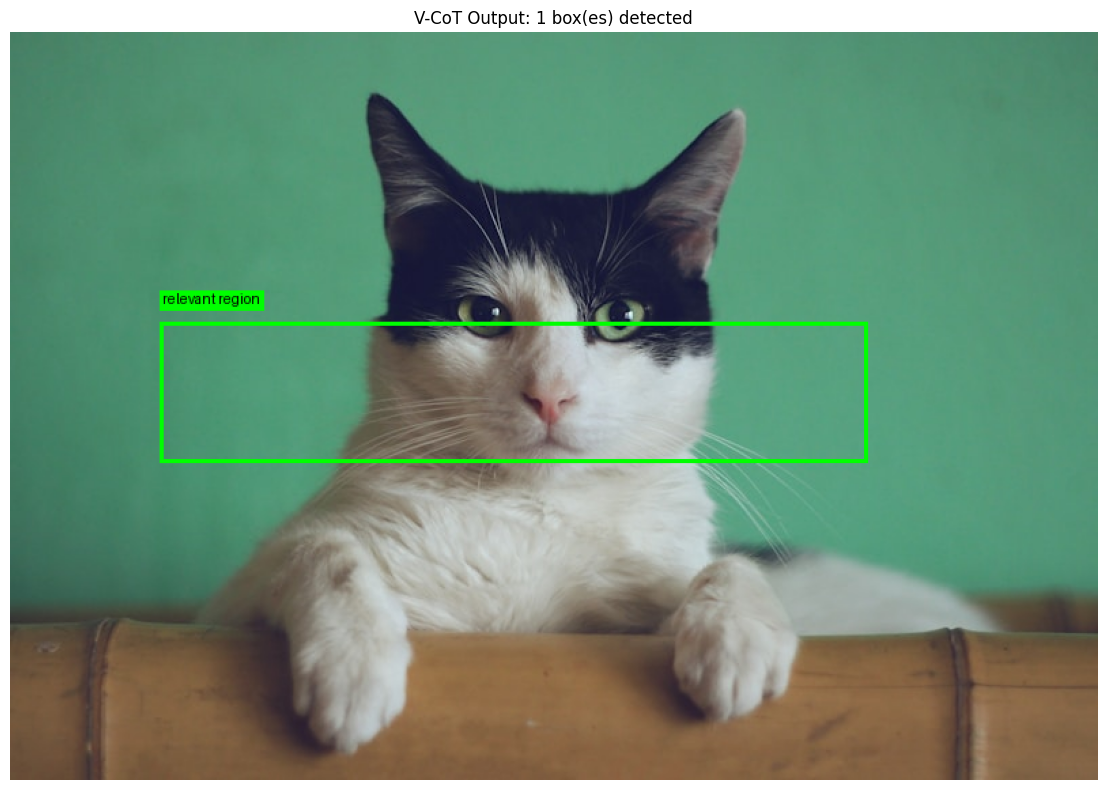

In [ ]:
#@title 4.2 Test Inference with Visualization { display-mode: "form" }
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
from qwen_vl_utils import process_vision_info
import re
import matplotlib.pyplot as plt

# Use a reliable test image URL
test_url = "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=800"

#@markdown ### Test prompt (ask for bounding boxes!)
test_question = "What is in this image? Please provide the bounding box coordinate of the region that shows the main subject."  #@param {type:"string"}

print(f"Question: {test_question}\n")

# Load image with proper headers
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
response = requests.get(test_url, headers=headers, timeout=10)
response.raise_for_status()
test_image = Image.open(BytesIO(response.content)).convert("RGB")
orig_w, orig_h = test_image.size
print(f"Image loaded: {test_image.size}")

# Prepare messages in Qwen2-VL format
messages = [{
    "role": "user",
    "content": [
        {"type": "image", "image": test_image},
        {"type": "text", "text": test_question}
    ]
}]

# Apply chat template to get the text prompt
text = inference_tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

# Process vision info and prepare inputs
image_inputs, video_inputs = process_vision_info(messages)
inputs = inference_tokenizer(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
).to("cuda")

# Generate with better parameters
with torch.no_grad():
    outputs = inference_model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=False,
        repetition_penalty=1.2,
        eos_token_id=inference_tokenizer.eos_token_id,
    )

# Decode only the new tokens
generated_ids = outputs[:, inputs.input_ids.shape[1]:]
response_text = inference_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Response:")
print("-" * 40)
print(response_text)
print("-" * 40)

# Parse bounding boxes from response
def parse_boxes(text):
    """Extract ref labels and bounding boxes from model output."""
    pattern = r"<ref>([^<]+)</ref><box>\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]</box>"
    matches = re.findall(pattern, text)
    results = []
    for match in matches:
        label = match[0]
        coords = [int(match[i]) for i in range(1, 5)]
        results.append({"label": label, "box": coords})
    return results

# Draw bounding boxes on image
def draw_boxes(image, boxes, orig_width, orig_height):
    """Draw bounding boxes on image. Coords are 0-1000 normalized."""
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)

    # Colors for multiple boxes
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF"]

    for i, box_info in enumerate(boxes):
        label = box_info["label"]
        x1, y1, x2, y2 = box_info["box"]

        # Convert from 0-1000 to pixel coordinates
        px1 = int((x1 / 1000) * orig_width)
        py1 = int((y1 / 1000) * orig_height)
        px2 = int((x2 / 1000) * orig_width)
        py2 = int((y2 / 1000) * orig_height)

        color = colors[i % len(colors)]

        # Draw rectangle (thick border)
        for offset in range(3):
            draw.rectangle([px1-offset, py1-offset, px2+offset, py2+offset], outline=color)

        # Draw label background
        label_text = label[:30] + "..." if len(label) > 30 else label
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 16)
        except:
            font = ImageFont.load_default()

        bbox = draw.textbbox((px1, py1-25), label_text, font=font)
        draw.rectangle([bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2], fill=color)
        draw.text((px1, py1-25), label_text, fill="black", font=font)

        print(f"Box {i+1}: '{label}' -> pixels [{px1}, {py1}, {px2}, {py2}]")

    return img_copy

# Parse and visualize
boxes = parse_boxes(response_text)

if boxes:
    print(f"\n✓ Found {len(boxes)} bounding box(es)!")
    result_image = draw_boxes(test_image, boxes, orig_w, orig_h)

    # Display the image with matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(result_image)
    plt.axis('off')
    plt.title(f"V-CoT Output: {len(boxes)} box(es) detected")
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠ No bounding boxes found in response.")
    plt.figure(figsize=(12, 8))
    plt.imshow(test_image)
    plt.axis('off')
    plt.title("Original Image (no boxes detected)")
    plt.show()



Test 1/6
Question: What is the dog doing? Please provide the bounding box coordinate of the dog.
Response: The dog appears to be running or walking on sand.

The <ref>The dog appears to be running </ref><box>[302, 74, 816, 598]</box> shows this in the image....
✓ Found 1 box(es)

Test 2/6
Question: What food is shown in this image? Please provide the bounding box coordinate of the main dish.
Response: The image shows a pizza.

The <ref>The image shows a pizza.</ref><box>[126, 984, 305, 997]</box> shows this in the image....
✓ Found 1 box(es)

Test 3/6
Question: Describe the vehicle in this image. Please provide the bounding box coordinate of the car.
Error: 404 Client Error: Not Found for url: https://images.unsplash.com/photo-1494976388531-d1058494ceb8?w=800

Test 4/6
Question: What is the person doing? Please provide the bounding box coordinate of the laptop.
Response: The person appears to be using or pointing at their open silver laptop.

The <ref>relevant region</ref><box>[148, 5

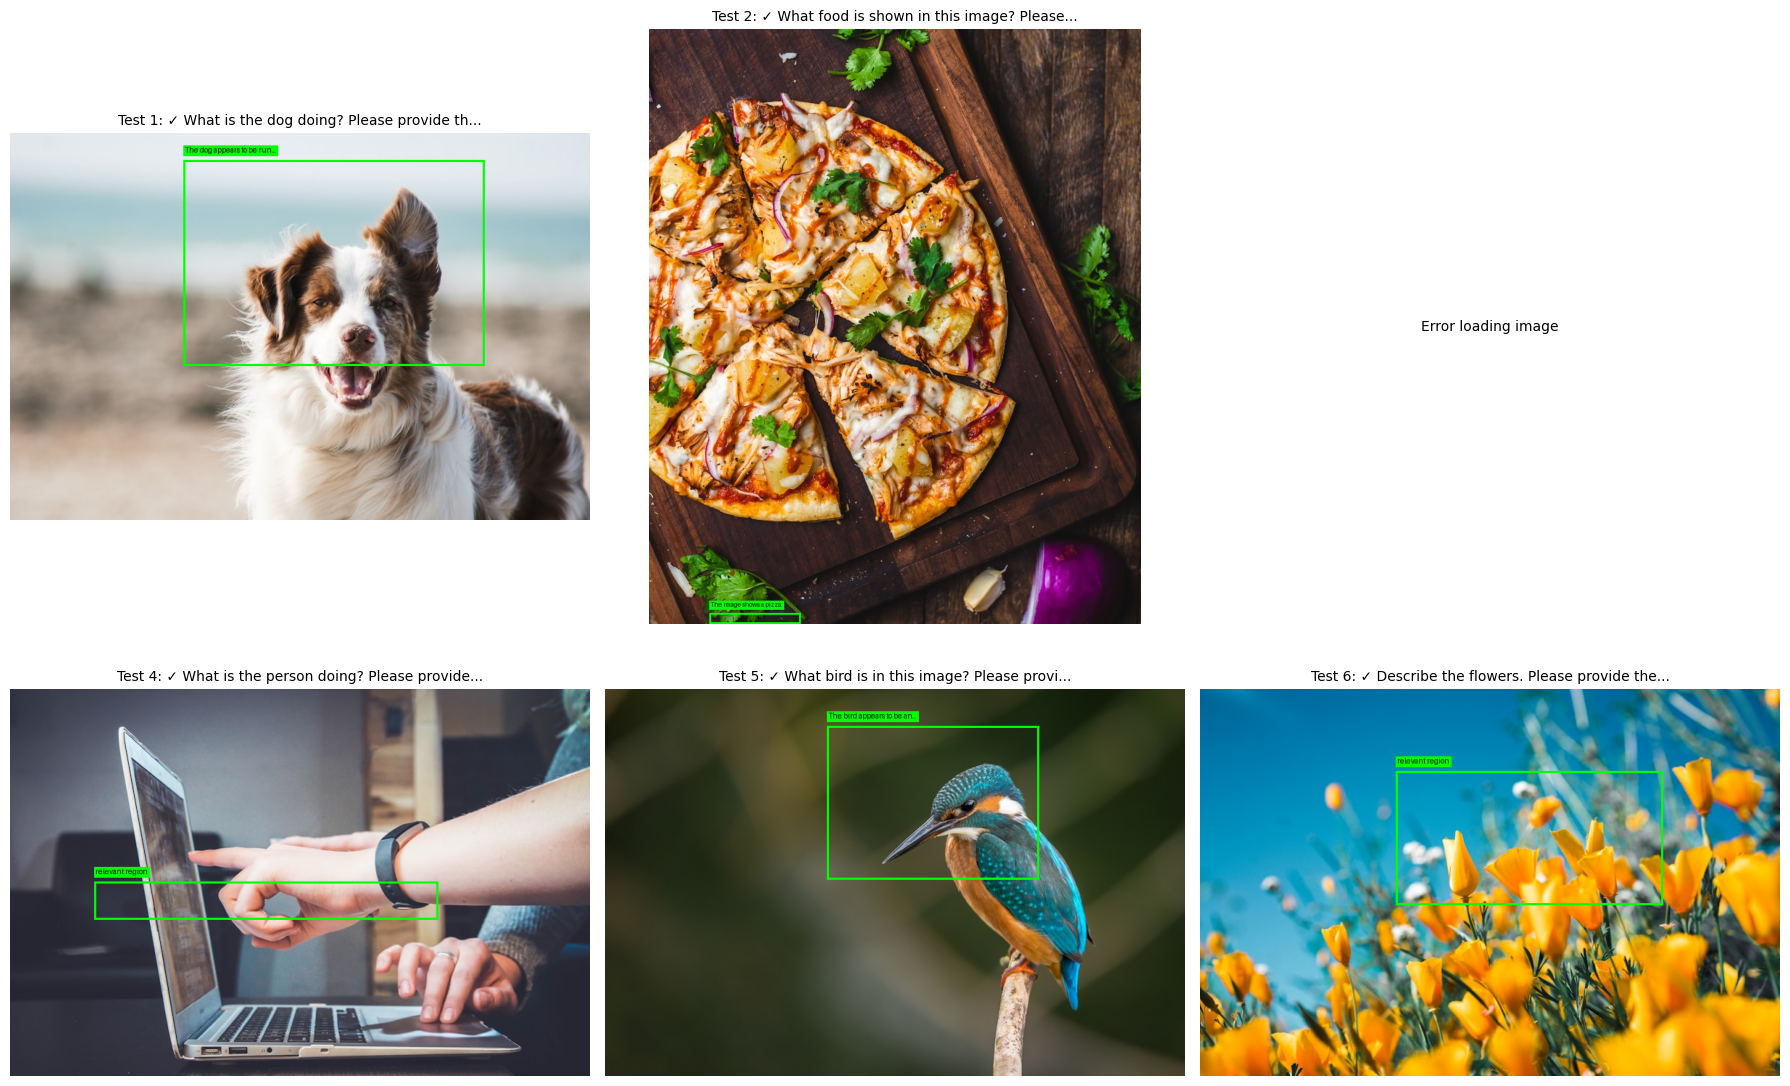

In [ ]:
#@title 4.3 Test Multiple Images { display-mode: "form" }
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
from qwen_vl_utils import process_vision_info
import re
import matplotlib.pyplot as plt

# Test cases: (image_url, prompt)
TEST_CASES = [
    # Dogs
    (
        "https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=800",
        "What is the dog doing? Please provide the bounding box coordinate of the dog."
    ),
    # Food
    (
        "https://images.unsplash.com/photo-1565299624946-b28f40a0ae38?w=800",
        "What food is shown in this image? Please provide the bounding box coordinate of the main dish."
    ),
    # Car
    (
        "https://images.unsplash.com/photo-1494976388531-d1058494ceb8?w=800",
        "Describe the vehicle in this image. Please provide the bounding box coordinate of the car."
    ),
    # Person with laptop
    (
        "https://images.unsplash.com/photo-1516321318423-f06f85e504b3?w=800",
        "What is the person doing? Please provide the bounding box coordinate of the laptop."
    ),
    # Bird
    (
        "https://images.unsplash.com/photo-1444464666168-49d633b86797?w=800",
        "What bird is in this image? Please provide the bounding box coordinate of the bird."
    ),
    # Flower
    (
        "https://images.unsplash.com/photo-1490750967868-88aa4486c946?w=800",
        "Describe the flowers. Please provide the bounding box coordinate of the main flower."
    ),
]

def parse_boxes(text):
    """Extract ref labels and bounding boxes from model output."""
    pattern = r"<ref>([^<]+)</ref><box>\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]</box>"
    matches = re.findall(pattern, text)
    results = []
    for match in matches:
        label = match[0]
        coords = [int(match[i]) for i in range(1, 5)]
        results.append({"label": label, "box": coords})
    return results

def draw_boxes(image, boxes, orig_width, orig_height):
    """Draw bounding boxes on image."""
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)
    colors = ["#00FF00", "#FF0000", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF"]

    for i, box_info in enumerate(boxes):
        label = box_info["label"]
        x1, y1, x2, y2 = box_info["box"]

        px1 = int((x1 / 1000) * orig_width)
        py1 = int((y1 / 1000) * orig_height)
        px2 = int((x2 / 1000) * orig_width)
        py2 = int((y2 / 1000) * orig_height)

        color = colors[i % len(colors)]
        for offset in range(3):
            draw.rectangle([px1-offset, py1-offset, px2+offset, py2+offset], outline=color)

        label_text = label[:25] + "..." if len(label) > 25 else label
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 14)
        except:
            font = ImageFont.load_default()

        bbox = draw.textbbox((px1, py1-22), label_text, font=font)
        draw.rectangle([bbox[0]-2, bbox[1]-2, bbox[2]+2, bbox[3]+2], fill=color)
        draw.text((px1, py1-22), label_text, fill="black", font=font)

    return img_copy

def run_inference(image, question):
    """Run model inference on an image."""
    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": question}
        ]
    }]

    text = inference_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = inference_tokenizer(text=[text], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = inference_model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,
            repetition_penalty=1.2,
            eos_token_id=inference_tokenizer.eos_token_id,
        )

    generated_ids = outputs[:, inputs.input_ids.shape[1]:]
    return inference_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

# Run all test cases
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}

# Create figure with subplots
n_tests = len(TEST_CASES)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (url, question) in enumerate(TEST_CASES):
    print(f"\n{'='*60}")
    print(f"Test {idx+1}/{n_tests}")
    print(f"Question: {question}")

    try:
        # Load image
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        test_image = Image.open(BytesIO(response.content)).convert("RGB")
        orig_w, orig_h = test_image.size

        # Run inference
        response_text = run_inference(test_image, question)
        print(f"Response: {response_text[:200]}...")

        # Parse and draw boxes
        boxes = parse_boxes(response_text)

        if boxes:
            print(f"✓ Found {len(boxes)} box(es)")
            result_image = draw_boxes(test_image, boxes, orig_w, orig_h)
        else:
            print("⚠ No boxes found")
            result_image = test_image

        # Plot
        axes[idx].imshow(result_image)
        axes[idx].set_title(f"Test {idx+1}: {'✓' if boxes else '✗'} {question[:40]}...", fontsize=10)
        axes[idx].axis('off')

    except Exception as e:
        print(f"Error: {e}")
        axes[idx].text(0.5, 0.5, f"Error loading image", ha='center', va='center')
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/test_results.png", dpi=150, bbox_inches='tight')
print(f"\n\n✓ Results saved to {CHECKPOINT_DIR}/test_results.png")
plt.show()


In [ ]:
#@title 4.4 Evaluation Metrics { display-mode: "form" }
import re

def parse_boxes(text):
    """Extract bounding boxes from model output."""
    pattern = r"<box>\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]</box>"
    matches = re.findall(pattern, text)
    return [[int(x) for x in match] for match in matches]

def calculate_iou(box1, box2):
    """Calculate IoU between two boxes."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    return inter / (area1 + area2 - inter + 1e-6)

def get_text_from_content(content):
    """Extract text from message content (handles both list and string formats)."""
    if isinstance(content, str):
        return content
    elif isinstance(content, list):
        for item in content:
            if isinstance(item, dict) and item.get("type") == "text":
                return item.get("text", "")
    return ""

# Load validation data if not already loaded
if 'val_data_raw' not in dir() or not val_data_raw:
    print("Loading validation data...")
    val_data_raw = load_jsonl(val_file)

print(f"Evaluating on {min(10, len(val_data_raw))} validation samples...\n")

num_with_boxes = 0
total_boxes = 0
total_gold_boxes = 0

for i, sample in enumerate(val_data_raw):  # Test first 10
    messages = sample.get("messages", [])
    if len(messages) < 2:
        continue

    # Get question from user message
    user_content = messages[0].get("content", "")
    question = get_text_from_content(user_content)

    # Get gold response and boxes
    gold_response = messages[1].get("content", "")
    gold_boxes = parse_boxes(gold_response)
    total_gold_boxes += len(gold_boxes)

    # Generate prediction (text-only, no image)
    pred_messages = [{"role": "user", "content": question}]

    # Use the text tokenizer for generation
    input_text = f"<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"
    inputs = text_tokenizer(input_text, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = inference_model.generate(
            **inputs,
            max_new_tokens=256,
            repetition_penalty=1.2,
            eos_token_id=text_tokenizer.eos_token_id,
        )

    pred_response = text_tokenizer.decode(outputs[0], skip_special_tokens=True)
    pred_boxes = parse_boxes(pred_response)

    if pred_boxes:
        num_with_boxes += 1
    total_boxes += len(pred_boxes)

    print(f"Sample {i+1}: {len(pred_boxes)} predicted, {len(gold_boxes)} gold | Q: {question[:50]}...")

print(f"\n{'='*50}")
print(f"EVALUATION SUMMARY")
print(f"{'='*50}")
print(f"Samples evaluated: {len(val_data_raw)}")
print(f"Samples with predicted boxes: {num_with_boxes}/{len(val_data_raw)} ({100*num_with_boxes/len(val_data_raw):.0f}%)")
print(f"Total boxes predicted: {total_boxes}")
print(f"Total gold boxes: {total_gold_boxes}")
print(f"\nNote: This evaluation runs without images (text-only).")
print(f"The model learned the output FORMAT but coordinates may not be accurate without images.")

Evaluating on 10 validation samples...

Sample 1: 1 predicted, 1 gold | Q: Can you tell me about the hairstyles of the indivi...
Sample 2: 1 predicted, 1 gold | Q: What are the young men doing with their hands? Ple...
Sample 3: 1 predicted, 1 gold | Q: What is the predominant color of the shirts worn b...
Sample 4: 1 predicted, 1 gold | Q: What type of setting are these individuals in? Ple...
Sample 5: 1 predicted, 1 gold | Q: Can you describe the attire of the individuals ope...
Sample 6: 1 predicted, 1 gold | Q: Are there any people standing on a high structure ...
Sample 7: 1 predicted, 1 gold | Q: Is there safety gear visible on the individuals wo...
Sample 8: 1 predicted, 1 gold | Q: What activity are the group of men engaged in on t...
Sample 9: 1 predicted, 1 gold | Q: What color is the dress of the child in this photo...
Sample 10: 1 predicted, 1 gold | Q: What is the child doing in this picture? Please pr...
Sample 11: 1 predicted, 1 gold | Q: Can you tell me the setting of th

---
## 5. Interactive Demo

In [ ]:
#@title 5.1 Launch Gradio Demo { display-mode: "form" }
import gradio as gr
import cv2
import numpy as np
import re
from PIL import Image
from transformers import TextIteratorStreamer
from threading import Thread

def stream_with_boxes(image, question):
    """Stream model response with live bounding box visualization."""
    if image is None:
        yield None, "Please upload an image."
        return

    # Convert to PIL if needed
    if isinstance(image, np.ndarray):
        pil_image = Image.fromarray(image)
        orig_h, orig_w = image.shape[:2]
        overlay = image.copy()
    else:
        pil_image = image
        orig_w, orig_h = image.size
        overlay = np.array(image)

    # Prepare input
    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": pil_image},
            {"type": "text", "text": question}
        ]
    }]

    inputs = inference_tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True
    ).to("cuda")

    # Setup streamer
    streamer = TextIteratorStreamer(inference_tokenizer, skip_prompt=True, decode_kwargs={"skip_special_tokens": False})
    gen_kwargs = dict(**inputs, streamer=streamer, max_new_tokens=512, use_cache=True)

    # Start generation in thread
    thread = Thread(target=inference_model.generate, kwargs=gen_kwargs)
    thread.start()

    generated_text = ""
    ref_pattern = re.compile(r"<ref>([^<]+)</ref><box>\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]</box>")

    for new_text in streamer:
        generated_text += new_text

        # Parse refs and boxes
        matches = ref_pattern.findall(generated_text)

        # Draw boxes
        current_overlay = overlay.copy()
        for match in matches:
            label = match[0]
            x1, y1, x2, y2 = [int(x) for x in match[1:]]

            # Denormalize
            ax1 = int((x1 / 1000) * orig_w)
            ay1 = int((y1 / 1000) * orig_h)
            ax2 = int((x2 / 1000) * orig_w)
            ay2 = int((y2 / 1000) * orig_h)

            # Draw
            cv2.rectangle(current_overlay, (ax1, ay1), (ax2, ay2), (0, 255, 0), 2)
            cv2.putText(current_overlay, label, (ax1, ay1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        yield current_overlay, generated_text

    thread.join()

# Create demo
with gr.Blocks(title="V-CoT Demo") as demo:
    gr.Markdown("# V-CoT: Grounded Visual Reasoning\n\nUpload an image and ask a question. The model will explain its reasoning with bounding boxes.")

    with gr.Row():
        with gr.Column():
            img_input = gr.Image(label="Input Image", type="numpy")
            txt_input = gr.Textbox(label="Question", value="Explain step by step what you see in this image.")
            btn = gr.Button("Generate", variant="primary")

        with gr.Column():
            img_output = gr.Image(label="Visualization")
            txt_output = gr.Textbox(label="Response", lines=10)

    btn.click(stream_with_boxes, [img_input, txt_input], [img_output, txt_output])

print("Launching demo...")
demo.launch(share=True, debug=True)

Launching demo...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9adee4b9fae3cad71b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://9adee4b9fae3cad71b.gradio.live


---
## 6. Utilities

In [ ]:
#@title 6.1 List Saved Checkpoints { display-mode: "form" }
import os
from datetime import datetime

print(f"Checkpoint directory: {CHECKPOINT_DIR}\n")

if os.path.exists(CHECKPOINT_DIR):
    items = os.listdir(CHECKPOINT_DIR)
    checkpoints = [d for d in items if d.startswith('checkpoint-') or d == 'final']

    if checkpoints:
        print(f"Found {len(checkpoints)} checkpoint(s):\n")
        for cp in sorted(checkpoints):
            cp_path = f"{CHECKPOINT_DIR}/{cp}"
            size = sum(os.path.getsize(os.path.join(cp_path, f)) for f in os.listdir(cp_path) if os.path.isfile(os.path.join(cp_path, f)))
            mtime = datetime.fromtimestamp(os.path.getmtime(cp_path))
            print(f"  📁 {cp}")
            print(f"     Size: {size/1e6:.1f} MB")
            print(f"     Modified: {mtime.strftime('%Y-%m-%d %H:%M:%S')}")
    else:
        print("No checkpoints found.")
else:
    print("Checkpoint directory does not exist.")

In [ ]:
#@title 6.2 Download Model to Local Machine { display-mode: "form" }
from google.colab import files
import shutil

DOWNLOAD_MODEL = False  #@param {type:"boolean"}

if DOWNLOAD_MODEL:
    model_to_download = f"{CHECKPOINT_DIR}/final"
    if os.path.exists(model_to_download):
        print("Creating zip archive...")
        shutil.make_archive("/content/vcot_model", 'zip', model_to_download)
        print("Starting download...")
        files.download("/content/vcot_model.zip")
    else:
        print(f"Model not found at {model_to_download}")
else:
    print("Set DOWNLOAD_MODEL = True to download the trained model.")

In [ ]:
#@title 6.3 Clean Up Old Checkpoints { display-mode: "form" }
KEEP_LAST_N = 2  #@param {type:"integer"}
CONFIRM_DELETE = False  #@param {type:"boolean"}

if os.path.exists(CHECKPOINT_DIR):
    checkpoints = sorted([d for d in os.listdir(CHECKPOINT_DIR) if d.startswith('checkpoint-')],
                        key=lambda x: int(x.split('-')[-1]))

    if len(checkpoints) > KEEP_LAST_N:
        to_delete = checkpoints[:-KEEP_LAST_N]
        print(f"Found {len(checkpoints)} checkpoints, keeping last {KEEP_LAST_N}")
        print(f"Will delete: {to_delete}")

        if CONFIRM_DELETE:
            for cp in to_delete:
                shutil.rmtree(f"{CHECKPOINT_DIR}/{cp}")
                print(f"  Deleted: {cp}")
            print("\n✓ Cleanup complete")
        else:
            print("\nSet CONFIRM_DELETE = True to actually delete.")
    else:
        print(f"Only {len(checkpoints)} checkpoints found, nothing to clean.")

---
## Quick Reference

### Resume Training
If your Colab session disconnects:
1. Run cells 1.1-1.5 (Setup)
2. Set `RESUME_FROM_CHECKPOINT = True` in cell 1.1
3. Run cells 3.1-3.4 (Training will resume from last checkpoint)

### Checkpoints Location
All checkpoints are saved to Google Drive at:
```
My Drive/Colab Notebooks/V-CoT/checkpoints/
```

### Model Loading
```python
from unsloth import FastVisionModel
model, tokenizer = FastVisionModel.from_pretrained(
    "/content/drive/MyDrive/Colab Notebooks/V-CoT/checkpoints/final"
)
```